# Importing libraries

In [ ]:
%pip install osmnx
%pip install rasterio
%pip install rasterstats
%pip install contextily
%pip install geopandas
%pip install matplotlib

In [61]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import random
from shapely.geometry import box
import contextily as ctx
import rasterio
import geopy.distance
from scipy.spatial import cKDTree
from rasterstats import zonal_stats
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import yaml
import pickle
import time
from scipy.sparse.csgraph import floyd_warshall

# Data

## Configs

In [62]:
with open("configs/params.yaml", "r") as f:
    config = yaml.safe_load(f)
    params = config

## City graph

In [63]:
def create_graph_network(city_params):
    G = ox.graph_from_place(city_params["name"], network_type = city_params["graph_type"])
    G.to_undirected()
    return G

In [64]:
G = ox.graph_from_place(params["city"]["name"], network_type="drive")

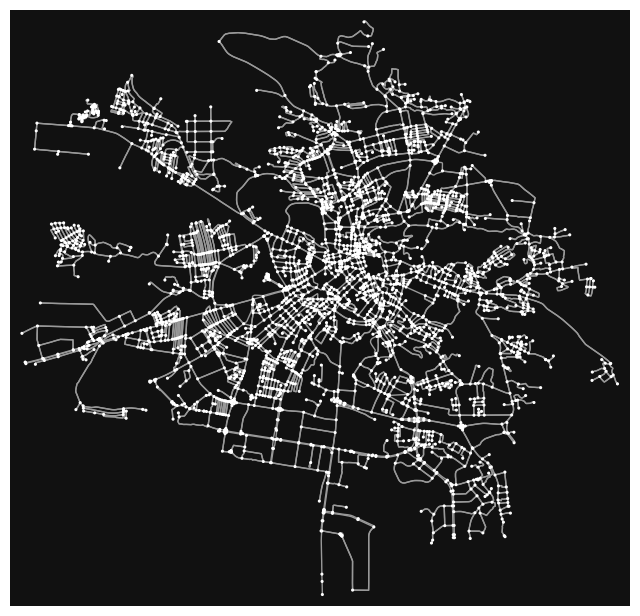

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [65]:
ox.plot_graph(G, node_size=5)

## Division into sectors

In [66]:
def division_into_secors(city_params):
    city_boundary = ox.geocode_to_gdf(city_params["name"])

    xmin, ymin, xmax, ymax = city_boundary.total_bounds
    grid_size = 0.0125

    grid_cells = []
    for x in np.arange(xmin, xmax, grid_size):
        for y in np.arange(ymin, ymax, grid_size):
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))

    grid = gpd.GeoDataFrame(geometry=grid_cells, crs=city_boundary.crs)
    map_with_grid = gpd.clip(grid, city_boundary)

    return map_with_grid, city_boundary

Assigning graph nodes to a grid cell (region)

In [67]:
def nodes_to_region(G, map_with_grid):
    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
    nodes_gdf = nodes_gdf.set_geometry(nodes_gdf.geometry)

    nodes_in_grid = gpd.sjoin(nodes_gdf, map_with_grid, how="left", predicate="within")
    nodes_in_grid = nodes_in_grid.reset_index()

    # Handling nodes that are not assigned to any grid cell. Creating node to region dictionary and region to nodes dictiionary
    assigned_nodes = nodes_in_grid.dropna(subset=["index_right"]) 
    missing_nodes = nodes_in_grid[nodes_in_grid["index_right"].isna()]

    tree = cKDTree(assigned_nodes[["x", "y"]].values)
    _, nearest_idx = tree.query(missing_nodes[["x", "y"]].values)

    nodes_in_grid.loc[nodes_in_grid["index_right"].isna(), "index_right"] = assigned_nodes.iloc[nearest_idx]["index_right"].values
    nodes_in_grid["index_right"] = nodes_in_grid["index_right"].astype(int)

    # region -> list of nodes
    region_to_nodes = nodes_in_grid.groupby(nodes_in_grid.index_right)["osmid"].apply(list).to_dict()
    # node -> region DI
    node_to_region = nodes_in_grid.set_index("osmid")["index_right"].to_dict()
    regions = [region for region in region_to_nodes]

    return regions, region_to_nodes, node_to_region


## Calculating population for each region

Population for each region

In [68]:
def population_estimation(regions, map_with_grid, city_params):
    
    # Population count for each sector
    raster_file_population = city_params["raster_file_population"]
    with rasterio.open(raster_file_population) as data:
        affine = data.transform
        array = data.read(1)
    stats = zonal_stats(map_with_grid, raster_file_population, stats=["sum"], affine=affine)
    map_with_grid["population"] = [s["sum"] if s["sum"] is not None else 0 for s in stats]
    map_with_grid = map_with_grid.reset_index()

    # Creating dictionary: region -> population
    region_to_populatoin = dict()
    for grid_cell in range(len(map_with_grid)):
        region_id = map_with_grid.iloc[grid_cell]["index"]
        if region_id in regions:
            population = map_with_grid.iloc[grid_cell]["population"]
            region_to_populatoin[region_id] = population
    
    return region_to_populatoin

## Distance matrix

In [69]:
def calculate_distamnce_matrix(G):
    nodes = list(G.nodes)
    n = len(nodes)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    # Creating adjacency matrix
    D = np.full((n, n), np.inf)

    for u, v, data in G.edges(data=True):
        length = data.get("length", np.inf)
        i, j = node_index[u], node_index[v]
        D[i, j] = length
        D[j, i] = length
    np.fill_diagonal(D, 0)

    # Using optimized Floyd-Warshall
    D = floyd_warshall(D, directed=False)
    np.save("distance_matrix_lviv.npy", D)
    return D


In [70]:
def distance_matrix(G, city_params):
    if city_params["distance_matrix"]:
        return np.load(city_params["distance_matrix"])
    return calculate_distamnce_matrix(G)

## Substations

In [71]:
def find_substations(city_name):
    substations = ox.features_from_place(city_name, tags={"power": "substation"})
    substations = substations[['geometry']].reset_index()
    return substations

In [72]:
def calculate_distance_to_substation(G, substations):
    dist_to_substation = dict()
    for node in G.nodes():
        node_lat, node_lon = G.nodes[node]['y'], G.nodes[node]['x']
        distances = []
        for _, row in substations.iterrows():
            if row.geometry.geom_type == "Point":
                substation_lat, substation_lon = row.geometry.y, row.geometry.x
                distance_m = geopy.distance.geodesic((node_lat, node_lon), (substation_lat, substation_lon)).m
                distances.append(distance_m)
        dist_to_substation[node] = min(distances)
    return dist_to_substation

# Demand simulation

## Data Preperation

In [73]:
def create_cs_dataframe(solution, station_params):
    # Merge installed station and solution station data
    station_node_list, capacity_list, station_ports_list  = [], [], []

    for (station_node, station_type), station_ports in solution.items():
        capacity = station_params["types"][station_type]["capacity"]

        station_node_list.append(station_node)
        capacity_list.append(capacity)
        station_ports_list.append(station_ports)

    # Create station dataframes
    charging_station_df = pd.DataFrame({
        "cs_id": range(len(station_node_list)),
        "node": station_node_list,
        "capacity": capacity_list,
        "num_of_ports": station_ports_list,
    })
    return charging_station_df

In [74]:
def create_cs_occupation_dataframe(charging_station_df, simulation_hours):
    cs_occupation_df = pd.DataFrame(columns=["cs_id", "capacity", "port", "hour", "occupation_time"])
    
    for _, row in charging_station_df.iterrows():
        cs_id = row["cs_id"]
        capacity = row["capacity"]
        number_of_ports = int(row["num_of_ports"])

        # Creating rows for each port and hour
        for port in range(1, number_of_ports + 1):
            for hour in range(simulation_hours):
                cs_occupation_df.loc[len(cs_occupation_df)] = {"cs_id": cs_id, "capacity": capacity, "port": port, "hour": hour, "occupation_time": 0.0}

    cs_occupation_df["cs_id"] = cs_occupation_df["cs_id"].astype(int)
    return cs_occupation_df

## EV generation

In [75]:
def generate_route(ev, nodes, rng):
    locations = []
    departure_times = []

    # Fron home
    home_location = ev["home_location"]
    morning_commute_hour = ev["commute_hours"]["morning"]
    
    # Route destinations
    number_of_destinations = rng.choices([1, 2, 3], weights = [0.6, 0.3, 0.1], k=1)[0] # Generating number of destinations that are not home
    
    locations.append(home_location) # Home location (start point)
    random_locations = rng.choices(nodes, k = number_of_destinations) # Work and other locations
    for location in random_locations:
        while location == home_location:
                location = rng.choice(nodes)
        locations.append(location)
    locations.append(home_location) # Home location (end point)

    # Route times
    trip_time = {
        "random morning trip": range(0, ev["commute_hours"]["morning"]),
        "random noon trip": range(ev["commute_hours"]["morning"], ev["commute_hours"]["evening"]),
        "random evening trip": range(ev["commute_hours"]["evening"], 24)
    }
    
    departure_times.append(morning_commute_hour) # Departure to work

    if number_of_destinations > 1:
        for i in range(number_of_destinations-1):
            ranom_trip_type = rng.choice(["random morning trip", "random noon trip", "random evening trip"])
            random_trip_time = rng.choice(trip_time[ranom_trip_type])
            departure_times.append(random_trip_time)

    departure_times.append(ev["commute_hours"]["evening"]) # Departure from work
    departure_times.sort()

    parking_periods = []
    for i in range(number_of_destinations + 2): # +2 since the route starts and ends at home
        if i == 0:
            parking_periods.append([0, departure_times[i]-1])
        elif i == number_of_destinations + 1:
            parking_periods.append([departure_times[i-1], 23])
        else:
            parking_periods.append([departure_times[i-1], departure_times[i]-1])
    return locations, parking_periods

In [76]:
def generate_EVs(regions, region_to_population, region_to_nodes, nodes, params, rng):
    EVs = []
    ev_id = 0

    for region in regions:
        ev_num = int(region_to_population[region] * params["ev"]["ev_per_capita"])

        potential_home_locations = region_to_nodes[region]
        if len(potential_home_locations) == 0:
            break
        ev_home_locations = rng.choices(potential_home_locations, k = ev_num)
        for i in range(ev_num):
            battery_capacity = params["ev"]["battery_capacity"]
            initial_soc_range = params["simulation"]["initial_soc_range"]
            charging_threshold = params["simulation"]["charging_threshold"]
            target_charge = params["simulation"]["target_charge"]
            morning_commute_hours = params["simulation"]["commute_hours"]["morning"]
            evening_commute_hours = params["simulation"]["commute_hours"]["evening"]

            ev = {
                    "ev_id": ev_id,
                    "home_location": ev_home_locations[i],
                    "previous_location": ev_home_locations[i],
                    "battery_capacity": rng.uniform(battery_capacity[0], battery_capacity[1]),
                    "current_charge": None,  # Will be assigned below
                    "charging_threshold": rng.uniform(charging_threshold[0], charging_threshold[1]),  # When to start charging
                    "target_charge": rng.uniform(target_charge[0], target_charge[1]),  # Target charge level
                    "commute_hours": {
                        "morning": rng.randint(morning_commute_hours[0], morning_commute_hours[1]),  # Morning commute hour (6-9 AM)
                        "evening": rng.randint(evening_commute_hours[0], evening_commute_hours[1])  # Evening commute hour (4-7 PM)
                    },
                    "destinations": None,  # Will be assigned below
                    "parking_periods": None  # Will be assigned below
            }
            
            # Assigning current state of charge
            ev["current_charge"] = ev["battery_capacity"] * rng.uniform(initial_soc_range[0], initial_soc_range[1])

            # Assigning route (destinations + departure_times)
            destinations, parking_periods = generate_route(ev, nodes, rng)
            ev["destinations"] = destinations
            ev["parking_periods"] = parking_periods
            EVs.append(ev)
            ev_id +=1
    return EVs

## EV charging

In [77]:
def needs_charge(ev):
    return (ev["current_charge"] < ev["battery_capacity"]*ev["charging_threshold"])

In [78]:
def nearest_cs_search(charging_station_df, current_location, dist_matrix, nodes_id):
    nearest_cs = charging_station_df.copy()

    nearest_cs["distance"] = nearest_cs["node"].apply(lambda x: dist_matrix[nodes_id[current_location], nodes_id[x]])
    nearest_cs = nearest_cs.sort_values(by = ["distance", "capacity"], ascending=[True, False])
    return nearest_cs[nearest_cs["distance"] < float("inf")]

In [79]:
def charge_ev(nearest_cs_df, charging_session_df, cs_occupation_df, hour, ev, params):
    # Calculating needed energy
    energy_needed = ev["battery_capacity"] * ev["target_charge"] - ev["current_charge"]
    total_energy_needed = energy_needed/(1-params["charging_stations"]["energy_loss"])
    
    # Calculating departure time (from charging station to next location)
    for j in range(len(ev["parking_periods"])):
        parking_period_start, parking_period_end = ev["parking_periods"][j]
        if hour in range(parking_period_start, parking_period_end + 1):
            departure_time = parking_period_end + 1

    # Searching for a nearest charging station
    while True:
        if len(nearest_cs_df) == 0:
            print("No charhing station is reachable")
            return charging_session_df, cs_occupation_df, ev

        for i in range(len(nearest_cs_df)):
            charging_station_data = nearest_cs_df.iloc[i]
            cs_node = charging_station_data["node"]
            cs_id = charging_station_data["cs_id"]
            cs_capacity = charging_station_data["capacity"]
            num_of_ports = int(charging_station_data["num_of_ports"])
            distance = charging_station_data["distance"]
            # Searching for a free port
            for port in range(1, num_of_ports + 1):
                port_occupation_data = cs_occupation_df[(cs_occupation_df["cs_id"]==cs_id) & (cs_occupation_df["hour"]==hour)&(cs_occupation_df["port"]==port)]
                port_occupation_time = port_occupation_data["occupation_time"].iloc[0]
                if port_occupation_time < 60:
                    break
            if port_occupation_time < 60: # To exit the first For loop
                break

        # If at the current hour each port is occupied for 60 minutes
        # then it is necessary to search for a free port in the next hour, if the day hasn't ended
        if port_occupation_time != 60:
            break
        else:
            if hour + 1 < 24 and hour + 1 < departure_time:
                hour +=1
            else:
                return charging_session_df, cs_occupation_df, ev
        
    # Calculating charging time
    charging_time_minutes = (total_energy_needed/cs_capacity)*60
    # EV charges until it is time for the next trip or until it is charged
    charging_time_minutes = min(charging_time_minutes, max(0, (departure_time - hour)*60 - port_occupation_time))

    # Update charging station occupation dataframe
    if port_occupation_time + charging_time_minutes <=60:
        cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = port_occupation_time + charging_time_minutes
        charging_end_hour = hour
    else:
        cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = 60
        charging_time_left = charging_time_minutes + port_occupation_time - 60
        next_hour = hour + 1
        while charging_time_left > 60 and next_hour < 24:
            cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == next_hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = 60
            charging_time_left -= 60
            next_hour +=1
        if next_hour < 24:
            cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == next_hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = charging_time_left
        charging_end_hour = min(23, next_hour)

    # Add new session
    new_session = {
        "cs_id": cs_id,
        "node": cs_node,
        "capacity": cs_capacity,
        "port": port,
        "charging_start_hour": hour,
        "charging_end_hour": charging_end_hour,
        "session_duration": charging_time_minutes,
        "ev_id": ev["ev_id"],
        "distance_from_ev": distance,
        "energy_used": cs_capacity*(charging_time_minutes/60)
    }
        
    charging_session_df.loc[len(charging_session_df)] = new_session
    charging_session_df["cs_id"] = charging_session_df["cs_id"].astype(int)
    # Update EV data
    ev["current_charge"] = ev["current_charge"] + cs_capacity*(charging_time_minutes/60)
    ev["previous_location"] = cs_node

    return charging_session_df, cs_occupation_df, ev

## Demand Simulation

In [ ]:
def simulate_charging_demand(solution, params, region_to_population, node_to_region, region_to_nodes, dist_matrix, nodes_id):
    """
    Simulates EV charging behavior and station usage for a full day.
    Returns:
        pd.DataFrame (charging station data),
        pd.DataFrame (charging session data)
    """

    rng = random.Random(12)
    regions = list(region_to_population.keys())
    nodes = list(node_to_region.keys())
    simulation_hours = params["simulation"]["simulation_hours"]

    charging_station_df = create_cs_dataframe(solution, params["charging_stations"])

    charging_session_df = pd.DataFrame(columns = ["cs_id", "node", "capacity", "port", "charging_start_hour", \
                                          "charging_end_hour", "session_duration", "ev_id", "distance_from_ev", "energy_used"])
    charging_session_df["cs_id"] = charging_session_df["cs_id"].astype(int)
    charging_session_df["node"] = charging_session_df["node"].astype(int)

    cs_occupation_df = create_cs_occupation_dataframe(charging_station_df, simulation_hours)

    # For each region initialize ev
    EVs = generate_EVs(regions, region_to_population, region_to_nodes, nodes, params, rng)

    avg_consumption_per_km = params["ev"]["avg_consumption_per_km"] #Wh/km

    # Simulate each hour
    for hour in range(simulation_hours):

        # For each EV
        for i in range(len(EVs)):
            ev = EVs[i]
            
            previous_location = ev["previous_location"]
            # Update location and state of charge
            for j in range(len(ev["parking_periods"])):
                parking_period_start, parking_period_end = ev["parking_periods"][j]
                if hour in range(parking_period_start, parking_period_end + 1):
                    current_location = ev["destinations"][j]
                    break
            if previous_location != current_location:
                distance = dist_matrix[nodes_id[previous_location], nodes_id[current_location]]
                energy_used = distance * (avg_consumption_per_km/1000)
                ev["current_charge"] -= energy_used

            # Charge if needed
            if needs_charge(ev):
                nearest_cs_df = nearest_cs_search(charging_station_df, current_location, dist_matrix, nodes_id)
                charging_session_df, cs_occupation_df, ev = charge_ev(nearest_cs_df, charging_session_df, cs_occupation_df, hour, ev, params)

            ev["previous_location"] = current_location
    
    return cs_occupation_df, charging_session_df

# Fitness Evaluation

### 1) CS cost evaluation

Total CS cost:\
$cs\_cost = \sum^N_{i=1}\sum_{n \in cs\_type} cost_{n,i}*X_{n,i}$

In [81]:
def cs_cost_penalty(solution, station_params):
    total_cost = 0
    for charging_station in solution:
        cs_type = charging_station[1]
        cost = station_params["types"][cs_type]["cost"]
        number_of_ports = solution[charging_station]
        total_cost += cost*number_of_ports
    return total_cost

### 2) Average charging time per 1kWh evaluation

In [82]:
def avg_time_per_kWh(charging_session_data):
    return sum(charging_session_data["session_duration"])/(sum(charging_session_data["energy_used"])/1000)

### 3) Average distance to charging station evaluation

In [83]:
def average_distance_to_cs(charging_session_data):
    return charging_session_data["distance_from_ev"].mean()

### 4) Grid loss

In [84]:
def total_grid_loss(solution, distance_to_substations):
    total_distance = 0
    for station in solution:
        cs_node = station[0]
        total_distance += distance_to_substations[cs_node]
    return total_distance

### Evaluation function

$evaluation = \alpha*cs\_cost + \beta*avg\_time\_per\_kWh + \gamma*avg\_distance + \delta*grid\_loss$

In [85]:
def evaluate_fitness(solution, params, dist_matrix, region_to_population, node_to_region, region_to_nodes, nodes_id, distance_to_substations):
    alpha = params["evaluation_weights"]["alpha"]
    beta = params["evaluation_weights"]["beta"]
    gamma = params["evaluation_weights"]["gamma"]
    delta = params["evaluation_weights"]["delta"]

    cs_occupation_df, charging_session_data = simulate_charging_demand(solution, params, region_to_population, node_to_region, region_to_nodes,
                                dist_matrix, nodes_id)

    cs_cost = cs_cost_penalty(solution, params["charging_stations"])
    avg_charging_time_kWh = avg_time_per_kWh(charging_session_data)
    avg_distance= average_distance_to_cs(charging_session_data)
    grid_loss = total_grid_loss(solution, distance_to_substations)

    fitness = alpha*cs_cost + beta*avg_charging_time_kWh + gamma*avg_distance + delta*grid_loss
    return fitness, alpha*cs_cost, beta*avg_charging_time_kWh, gamma*avg_distance, delta*grid_loss

# Particle Swarm Optimization

**The form in which the solution is presented:**\
$x\ =\ \{$ \
$\ \ \ \ (i, 'station\_type'): n$ \
$\}$

Where\
$i$ - node_id,\
$n$ - number of stations (of this type) in the node $i$

## Population initialization

In [86]:
def initialize_particles(nodes, station_types, num_particle):

    particles = []
    velocities = []
    for i in range(num_particle):
        solution = {}

        velocity = {}
        for node in random.sample(nodes, k=random.randint(5, 100)):
            cs_type = random.choice(station_types)
            cs_number = random.choices([1,2,3,4], [0.3, 0.4, 0.2, 0.1])[0]
            solution[(node, cs_type)] = cs_number
            velocity[(node, cs_type)] = 0
        particles.append(solution)
        velocities.append(velocity)
    return particles, velocities

## Update velocities of particles

$v^{t+1}_i = w * v^t_i + c_1*r_1(p_{best} - x_i) + c_2*r_2(g_{best} - x_i) $

- $w$ - inertia weight (controls exploration vs exploitation)\
- $c_1$, $c_2$ - acceleration coefficients (how strongly the particle moves toward the best positions)\
- $r_1$, $r_2$  - random numbers (to add stochastic behavior)\
- $x_i$ - current position of the particle\
- $v_i$ - current velocity of the particle\
- $p_best$ - best position found by the particle\
- $g_best$ - best position found by any particle

In [88]:
def update_velocity(particle, velocity, personal_best, global_best, pso_params):

    w = pso_params["w"]
    c1 = pso_params["c1"]
    c2 = pso_params["c2"]

    new_velocity = dict()
    all_stations = set(particle.keys())
    all_stations = all_stations.union(personal_best.keys())
    all_stations = all_stations.union(global_best.keys())
    for station in all_stations:

        if station in personal_best:
            p_best_ports = personal_best[station]
        else:
            p_best_ports = 0

        if station in global_best:
            g_best_ports = global_best[station]
        else:
            g_best_ports = 0

        if station in particle:
            particle_ports = particle[station]
        else:
            particle_ports = 0

        p_best_diff = p_best_ports - particle_ports
        g_best_diff = g_best_ports - particle_ports
        
        new_velocity[station] = int(w * velocity.get(station, 0) + c1 * random.random() * p_best_diff + c2 * random.random() * g_best_diff)

    return new_velocity

## Update positions of particles

$x^{t+1}_i = x^t_i + v^{t+1}_i$

In [89]:
def update_particle(particle, velocity, max_ports_per_station):

    new_particle = particle.copy()
    all_stations = velocity.keys()

    for station in all_stations:
        change = velocity[station]

        if station in new_particle.keys():
            cs_ports = new_particle[station]
        else: 
            cs_ports = 0

        new_cs_ports = max(0, min(cs_ports + change, max_ports_per_station))
        new_particle[station] = new_cs_ports

        if new_particle[station] == 0:
            new_particle.pop(station)
        
    return new_particle

## Mutation

In [100]:
import random

def mutate(solution, nodes, cs_types, max_ports_per_station, mutation_rate = 0.10):

    if random.random() >= mutation_rate: # No mutation
        return solution
    
    action = random.choice(["add", "remove", "change_type"])

    if action == "remove":  # Remove random stations
        num_of_stations = random.choices([1, 2, 3, 4], [0.4, 0.3, 0.2, 0.1])[0]
        for i in range(num_of_stations):
            random_cs = random.choice([cs for cs in solution])
            num_of_ports = random.choice(range(0, solution[random_cs]))
            if num_of_ports < solution[random_cs]:
                solution[random_cs] = solution[random_cs] - num_of_ports
            else:
                solution.pop(random_cs)
    elif action == "add":  # Add a new stations
        num_of_stations = random.choices([1, 2, 3, 4], [0.4, 0.3, 0.2, 0.1])[0]
        for i in range(num_of_stations):
            random_node = random.choice(nodes)
            cs_type = random.choice(cs_types)
            num_of_ports = random.choice(range(1, 4))
            if (random_node, cs_type) in solution:
                solution[(random_node, cs_type)] = min(4, solution[(random_node, cs_type)] + num_of_ports)
            else: 
                solution[(random_node, cs_type)] = num_of_ports
    else:  # Change station type
        num_of_stations = random.choices([1, 2, 3, 4], [0.4, 0.3, 0.2, 0.1])[0]
        for i in range(num_of_stations):
            cs_node, cs_type = random.choice([cs for cs in solution])
            new_cs_types_list = cs_types.copy()
            new_cs_types_list.remove(cs_type)

            new_cs_type = random.choice(new_cs_types_list)
            if (cs_node, new_cs_type) in solution:
                solution[(cs_node, new_cs_type)] = min(max_ports_per_station, \
                                                        solution[(cs_node, cs_type)] + solution[(cs_node, new_cs_type)])
            else:
                solution[(cs_node, new_cs_type)] = solution[(cs_node, cs_type)]

            solution.pop((cs_node, cs_type))

    return solution

## Particle Swarm Optimization

In [104]:
def PSO_algorithm(G, dist_matrix, params, region_to_population, node_to_region, region_to_nodes, distance_to_substations):
    nodes = list(G.nodes)
    nodes_id = {nodes[i]: i for i in range(len(nodes))}
    
    pso_params = params["particle_swarm_optimization"]
    station_params = params["charging_stations"]
    cs_types = station_params["types_list"]
    num_particle = pso_params["particles"]
    iterations = pso_params["iterations"]
    station_params = params["charging_stations"]
    max_ports_per_station = station_params["max_ports_per_station"]

    particles, velocities = initialize_particles(nodes, cs_types, num_particle)

    # Fitness evaluation
    fitness = [evaluate_fitness(particle, params, dist_matrix, region_to_population,\
                                node_to_region, region_to_nodes, nodes_id, distance_to_substations) for particle in particles]
    total_fitness = [particle_fitness[0] for particle_fitness in fitness]

    p_best = particles.copy()
    p_best_fitness = fitness 
    g_best = particles[np.argmin(total_fitness)]
    g_best_fitness = fitness[np.argmin(total_fitness)]
    best_fitness_list = [g_best_fitness]

    
    for iteration in range(iterations):
        print("Iteration", iteration + 1, "/", iterations)

        # Update velocity and position of particle
        for i in range(len(particles)):
            velocities[i] = update_velocity(particles[i], velocities[i], p_best[i], g_best, pso_params)
            particles[i] = update_particle(particles[i], velocities[i], max_ports_per_station)
            particles[i] = mutate(particles[i], nodes, cs_types, max_ports_per_station)
            current_fitness = evaluate_fitness(particles[i], params, dist_matrix, region_to_population,\
                                node_to_region, region_to_nodes, nodes_id, distance_to_substations)
                                
            current_total_fitness = current_fitness[0]
            
            # Update p_best
            p_best_total_fitness = p_best_fitness[i][0]
            if current_total_fitness < p_best_total_fitness:
                p_best[i] = particles[i]
                p_best_fitness[i] = current_fitness

            # Update g_best
            g_best_total_fitness = g_best_fitness[0]
            if current_total_fitness < g_best_total_fitness:
                g_best = particles[i]
                g_best_fitness = current_fitness

        best_fitness_list.append(g_best_fitness)

    return g_best, best_fitness_list


## Visualization

In [91]:
def visualize_solution(solution, G):
    cs_lists_by_type = dict()
    for charging_station in solution:
        cs_node = charging_station[0]
        cs_type = charging_station[1]
        if cs_type in list(cs_lists_by_type.keys()):
            cs_lists_by_type[cs_type].append(cs_node)
        else:
            cs_lists_by_type[cs_type] = [cs_node]

    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    G_undirected = G.to_undirected()
    G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
    fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")


    nx.draw(G_undirected, pos, node_size=2, with_labels=False, node_color="darkgray", edge_color="darkgray", ax=ax)

    unique_cs_types = list(cs_lists_by_type.keys())
    color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))
                 for i, cs_type in enumerate(unique_cs_types)}

    # Drawing charging station nodes with different colors based on their type
    for cs_type, nodes in cs_lists_by_type.items():
        nx.draw_networkx_nodes(
            G_undirected,
            pos,
            nodelist=nodes,
            node_size=20,
            node_color=[color_map[cs_type]] * len(nodes),
            label=f"{cs_type} Stations",
            ax=ax
        )

    legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="white", edgecolor="darkgray", bbox_to_anchor=(1.5, 1))
    for text in legend.get_texts():
        text.set_color("black")

    plt.title("Graph with Stations", color="black")
    ax.axis("off")

    plt.tight_layout()
    plt.show()


In [92]:
def plot_total_fitness(best_fitness_list):
    plt.figure(figsize=(15, 10))
    fitness = [iteration[0] for  iteration in best_fitness_list]
    n = len(fitness)
    plt.plot(range(n), fitness, label = "Total evaluation")
    plt.xlabel('Iteration')
    plt.ylabel('Best fitness')
    plt.title(f'Total Fitness of the best solution for each iteration for PSO model')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [93]:
def plot_models_fitness(fitness_lists, parameters):
    plt.figure(figsize=(15, 10))

    fitness = [iteration[0] for  iteration in fitness_lists]
    fitness_cost = [iteration[1] for  iteration in fitness_lists]
    fitness_charging_time = [iteration[2] for  iteration in fitness_lists]
    fitness_avg_distance = [iteration[3] for  iteration in fitness_lists]
    fitness_grid_loss = [iteration[4] for  iteration in fitness_lists]
    n = len(fitness)
    plt.plot(range(n), fitness, label = "Total evaluation")
    plt.plot(range(n), fitness_cost, label = f"Cost evaluation, weight = {parameters['alpha']}")
    plt.plot(range(n), fitness_charging_time, label = f"Average charging time per kWh evaluation, weight = {parameters['beta']}")
    plt.plot(range(n), fitness_avg_distance, label = f"Average distance evaluation, weight = {parameters['gamma']}")
    plt.plot(range(n), fitness_grid_loss, label = f"Grid loss evaluation, weight = {parameters['delta']}")

    plt.xlabel('Iteration')
    plt.ylabel('Best fitness')
    plt.title(f'Fitness values of the best solution for each iteration for PSO')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Particle Swarm Optimization Model

In [94]:
def run_pso(base_config_file, exp_name, exp_config_file = None):
    with open(base_config_file, "r") as f:
        params = yaml.safe_load(f)
    
    if exp_config_file:
        with open(exp_config_file, "r") as f:
            exp_params = yaml.safe_load(f)
        params.update(exp_params)

    city_params = params["city"]

    # Graph
    G = create_graph_network(city_params)

    # Calculating distance matrix
    dist_matrix = distance_matrix(G, city_params)

    # Calculating distance from nodes to substations
    substations = find_substations(city_params["name"])
    distance_to_substations = calculate_distance_to_substation(G, substations)

    # Division into sectors + demand estimation
    map_with_grid, city_boundary = division_into_secors(city_params)
    regions, region_to_nodes, node_to_region = nodes_to_region(G, map_with_grid)
    region_to_population = population_estimation(regions, map_with_grid, city_params)

    # PSO
    start_time = time.time()

    best_solution, best_fitness_list = PSO_algorithm(G, dist_matrix, params, region_to_population, 
                                                    node_to_region, region_to_nodes, distance_to_substations)
    runtime = time.time() - start_time
    result = {
        "algorithm": "PSO",
        "fitness_history": best_fitness_list,
        "runtime": runtime,
        "solution": best_solution
    }
    with open(exp_name, 'wb') as f:
        pickle.dump(result, f)

    # Visualization
    # plot_models_fitness(best_fitness_list, params["evaluation_weights"])
    # plot_total_fitness(best_fitness_list)
    # visualize_solution(best_solution, G)

# Experiments

## Experiment 0

- base parameters

In [ ]:
run_pso("configs/params.yaml", "exp_pso_0.pkl", exp_config_file = None)

In [98]:
with open("exp_pso_0.pkl", "rb") as f:
    exp_result = pickle.load(f)
exp_result["runtime"]

6298.174238443375

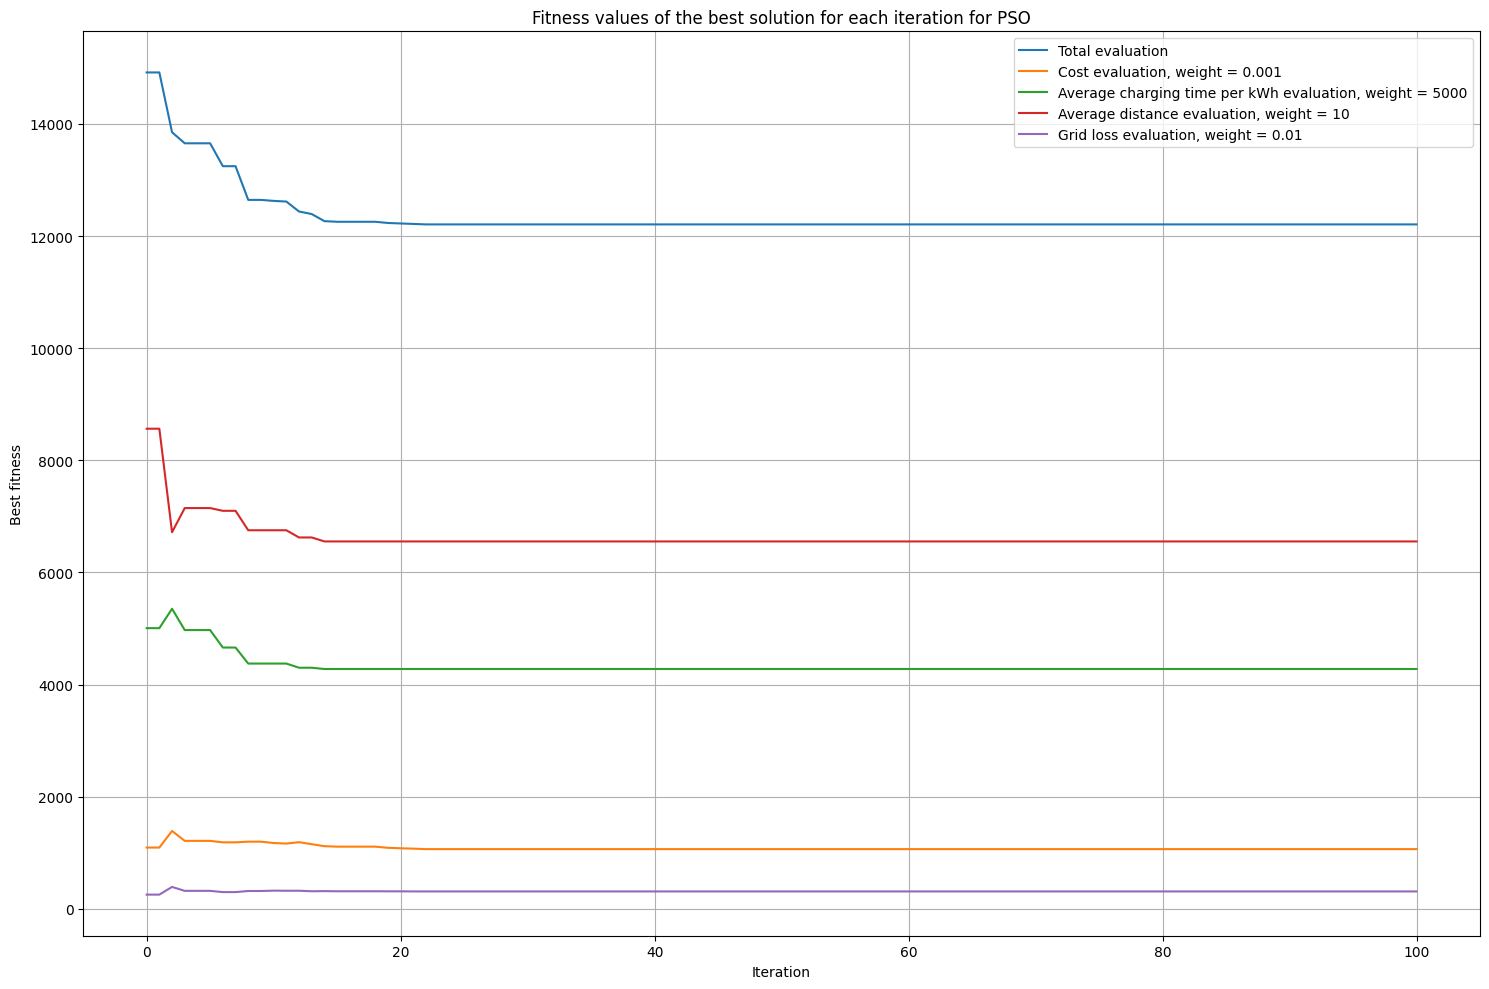

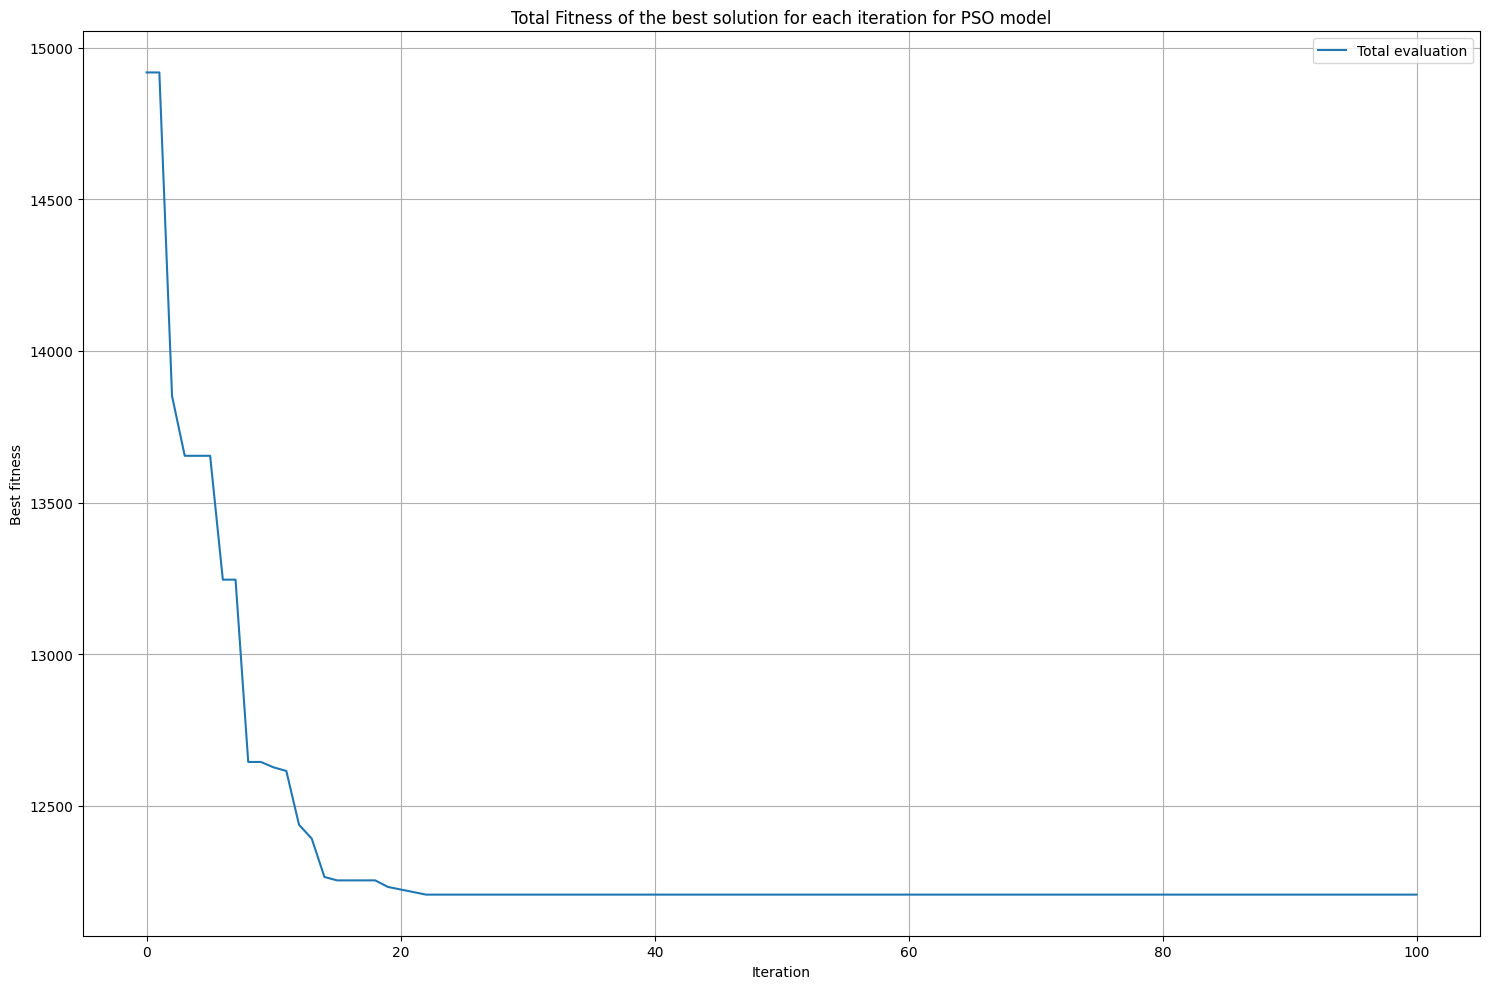

C:\Users\tetia\AppData\Local\Temp\ipykernel_39452\2865980958.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


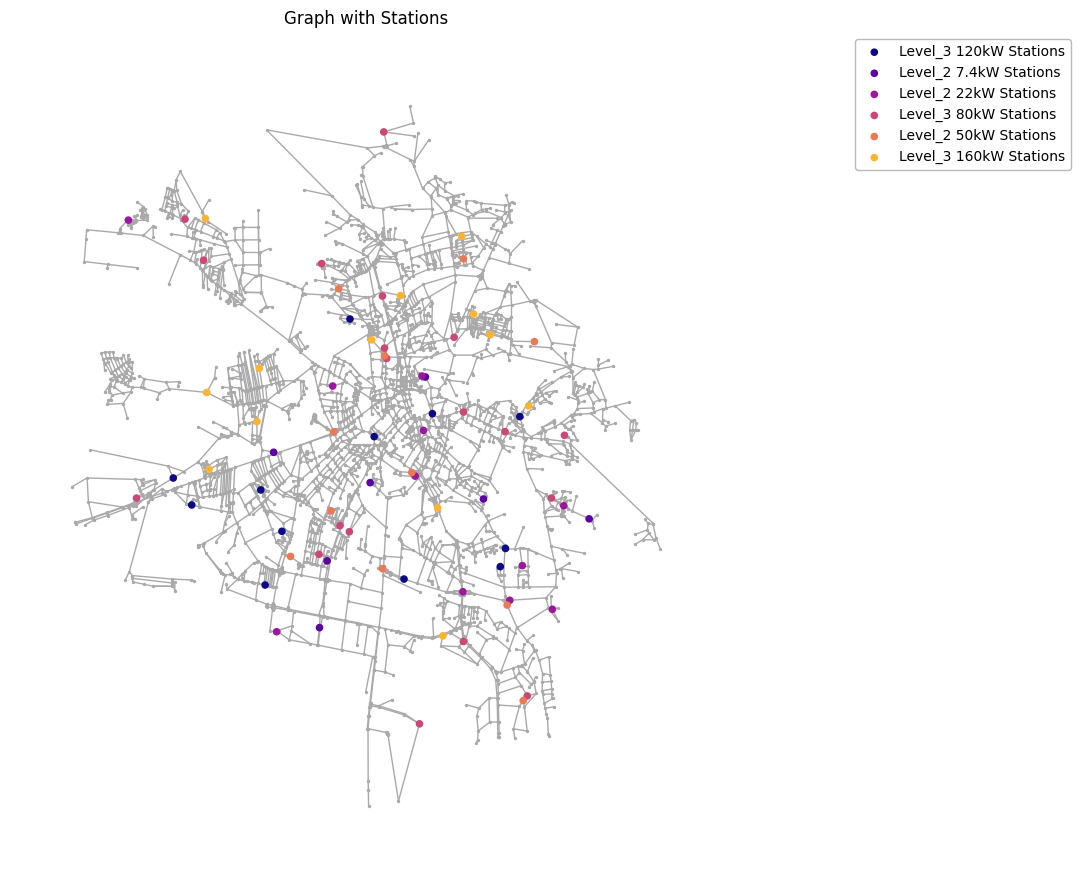

In [97]:
plot_models_fitness(exp_result["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result["fitness_history"])
visualize_solution(exp_result["solution"], G)

## Experiment 1

- base parameters
- mutation rate = 0.10

In [ ]:
run_pso("configs/params.yaml", "exp_pso_1.pkl", exp_config_file = "configs/experiments/exp_pso_1.yaml")

In [105]:
with open("exp_pso_1.pkl", "rb") as f:
    exp_result1 = pickle.load(f)
exp_result1["runtime"]

4682.267319202423

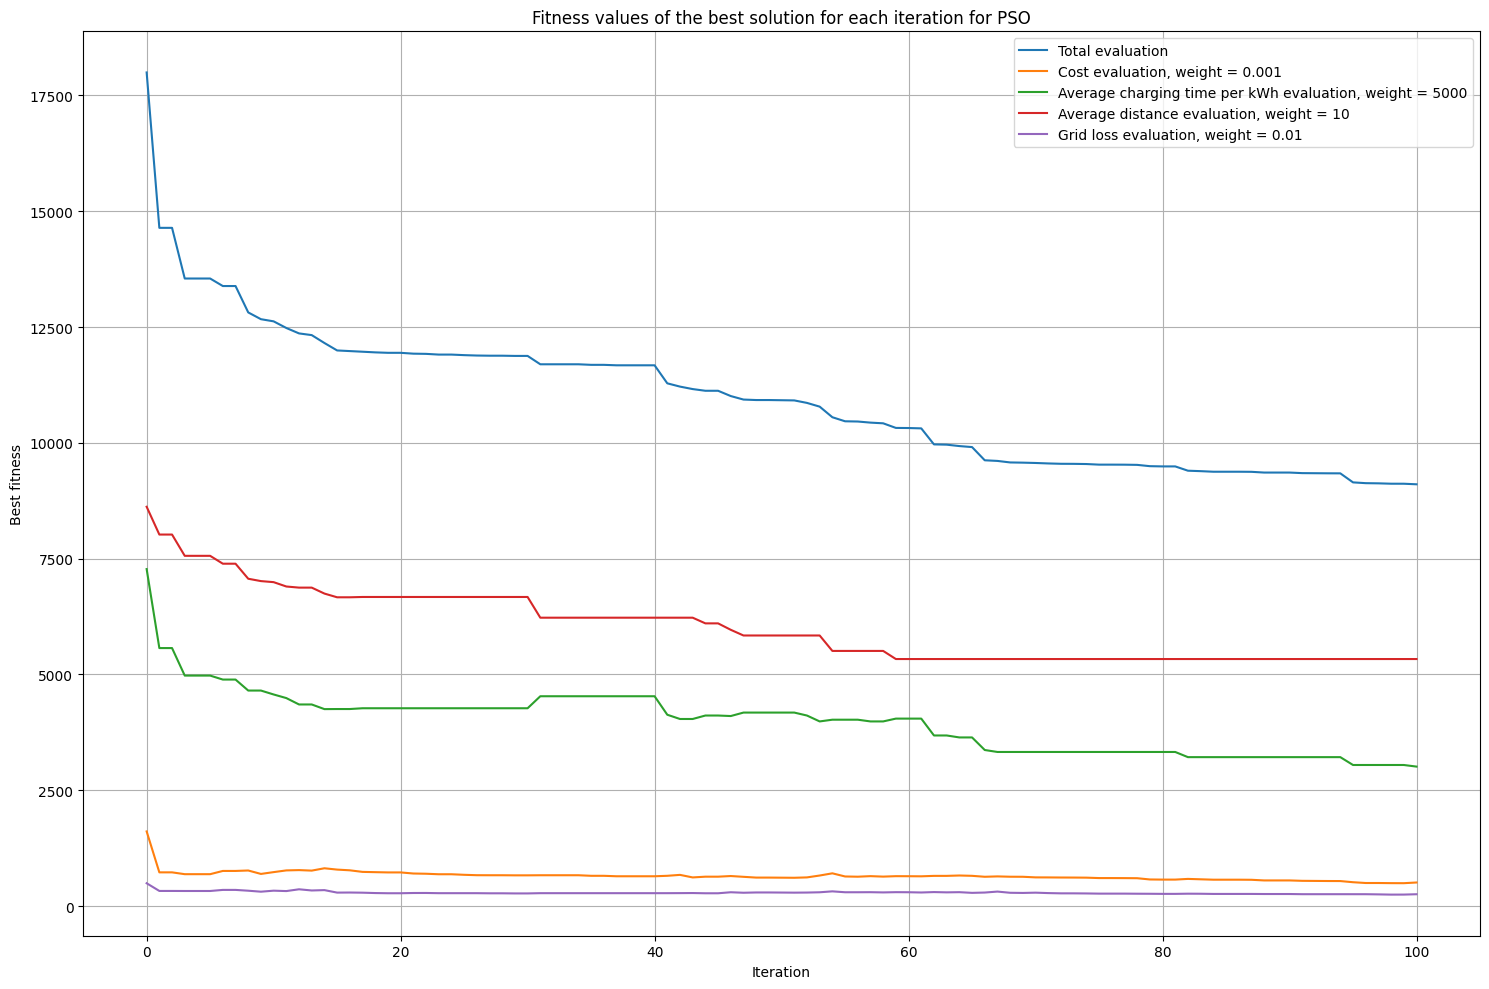

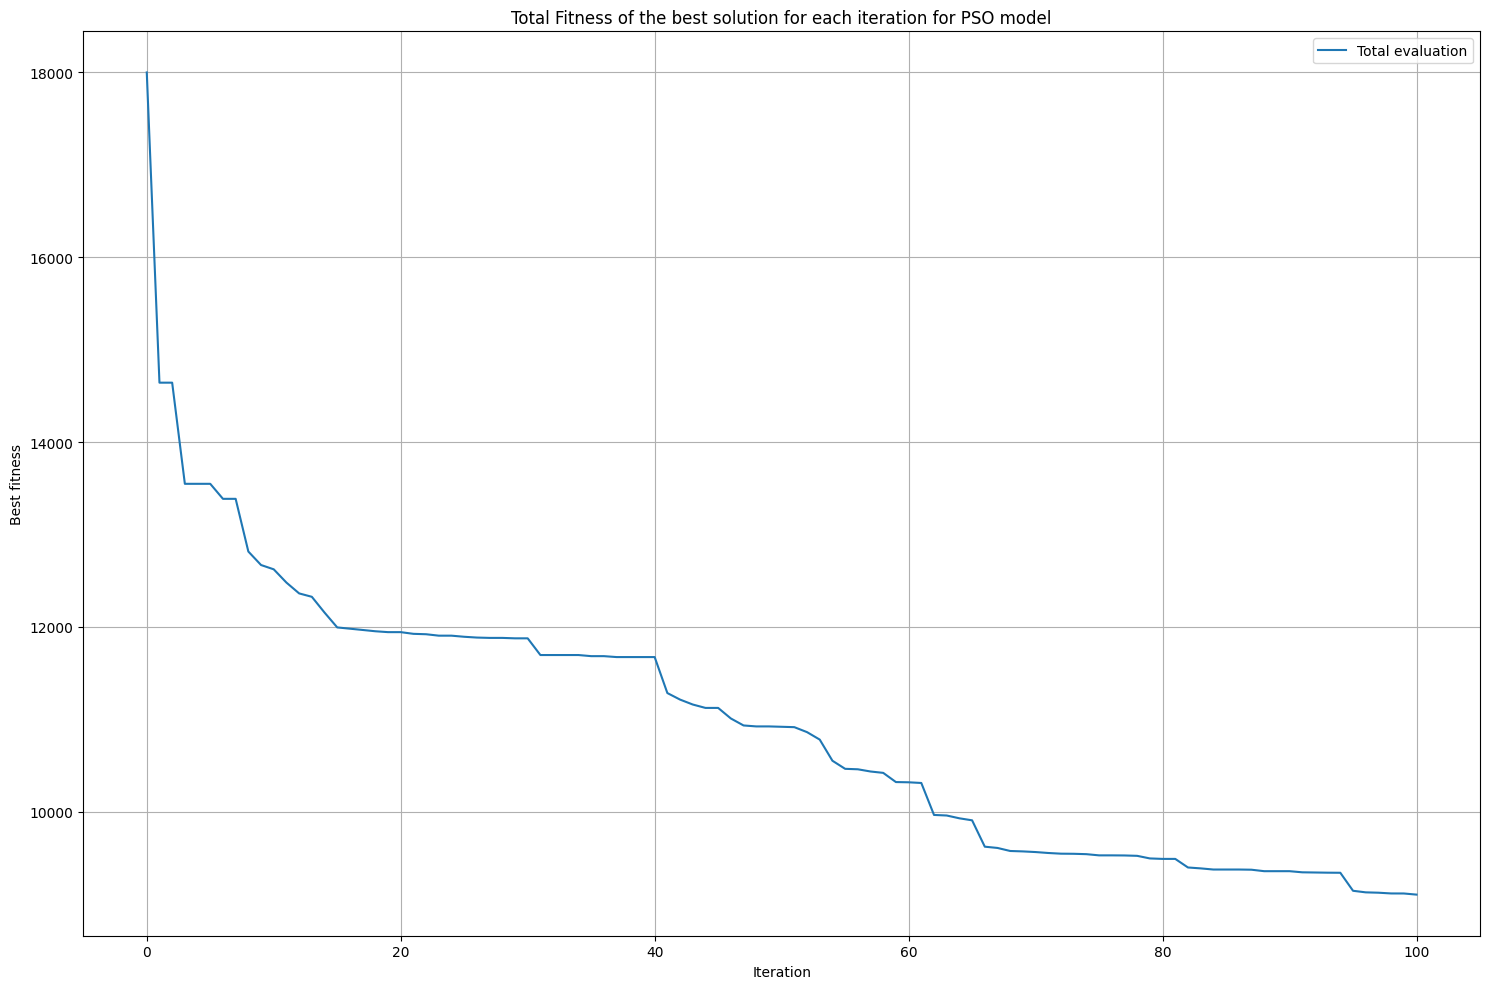

C:\Users\tetia\AppData\Local\Temp\ipykernel_39452\2865980958.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


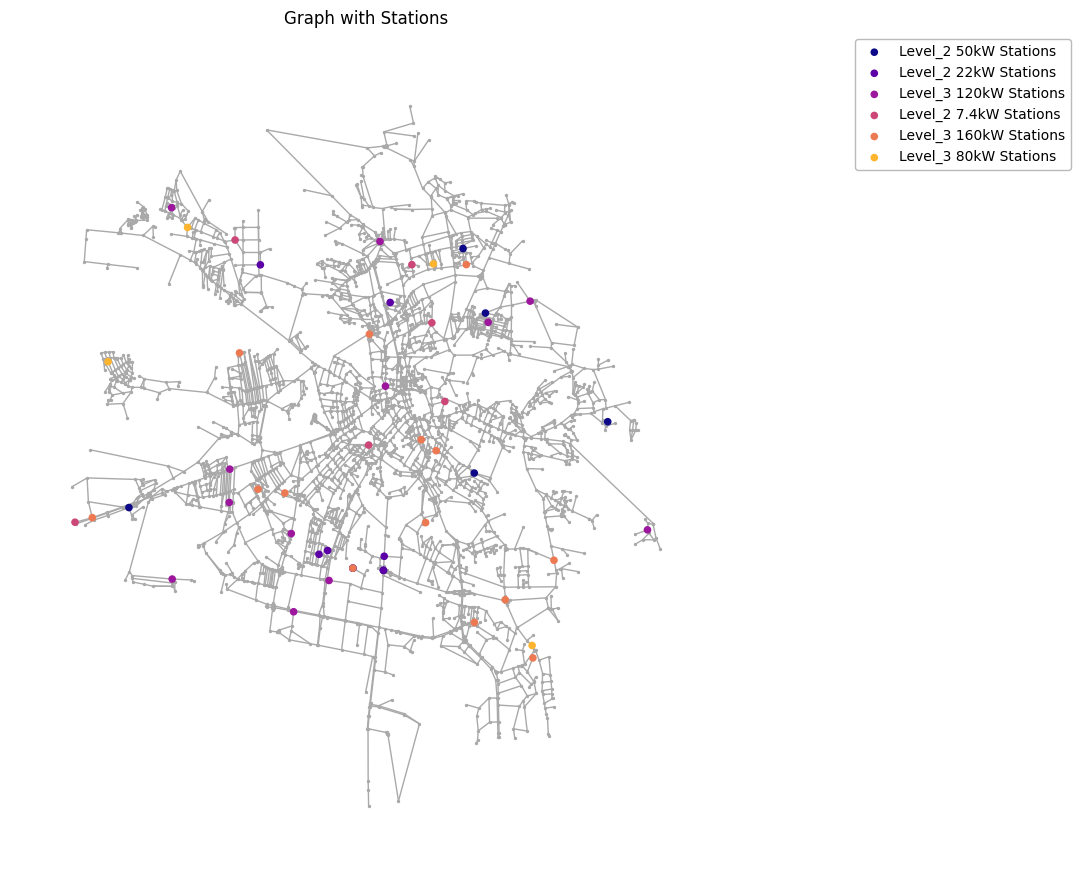

In [106]:
plot_models_fitness(exp_result1["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result1["fitness_history"])
visualize_solution(exp_result1["solution"], G)

## Experiment 2

- base parameters
- generations = 150

- base parameters
- generations = 200

In [ ]:
run_pso("configs/params.yaml", "exp_pso_2.pkl", exp_config_file = "configs/experiments/exp_pso_2.yaml")

Iteration 1 / 150
Iteration 2 / 150
Iteration 3 / 150
Iteration 4 / 150
Iteration 5 / 150


In [ ]:
with open("exp_pso_2.pkl", "rb") as f:
    exp_result2 = pickle.load(f)
exp_result2["runtime"]

In [ ]:
plot_models_fitness(exp_result2["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result2["fitness_history"])
visualize_solution(exp_result2["solution"], G)

## Experiment 3

- base parameters
- population size = 200

In [ ]:
run_pso("configs/params.yaml", "exp_pso_3.pkl", exp_config_file = "configs/experiments/exp_pso_3.yaml")

In [ ]:
with open("exp_pso_3.pkl", "rb") as f:
    exp_result3 = pickle.load(f)
exp_result3["runtime"]

In [ ]:
plot_models_fitness(exp_result3["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result3["fitness_history"])
visualize_solution(exp_result3["solution"], G)

## Experiment 4

- base parameters
- number of parents = 80

In [ ]:
run_pso("configs/params.yaml", "exp_pso_4.pkl", exp_config_file = "configs/experiments/exp_pso_4.yaml")

In [ ]:
with open("exp_pso_4.pkl", "rb") as f:
    exp_result4 = pickle.load(f)
exp_result4["runtime"]

In [ ]:
plot_models_fitness(exp_result4["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result4["fitness_history"])
visualize_solution(exp_result4["solution"], G)

## Experiment 5

- base parameters
- mutation rate = 0.2

In [ ]:
run_pso("configs/params.yaml", "exp_pso_5.pkl", exp_config_file = "configs/experiments/exp_pso_5.yaml")

In [ ]:
with open("exp_pso_5.pkl", "rb") as f:
    exp_result5 = pickle.load(f)
exp_result5["runtime"]

In [ ]:
plot_models_fitness(exp_result5["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result5["fitness_history"])
visualize_solution(exp_result5["solution"], G)

## Experiment 6

- base parameters
- population size = 200
- parents = 80

In [ ]:
run_pso("configs/params.yaml", "exp_pso_6.pkl", exp_config_file = "configs/experiments/exp_pso_6.yaml")

In [107]:
with open("exp_pso_6.pkl", "rb") as f:
    exp_result6 = pickle.load(f)
exp_result6["runtime"]

10087.861726045609

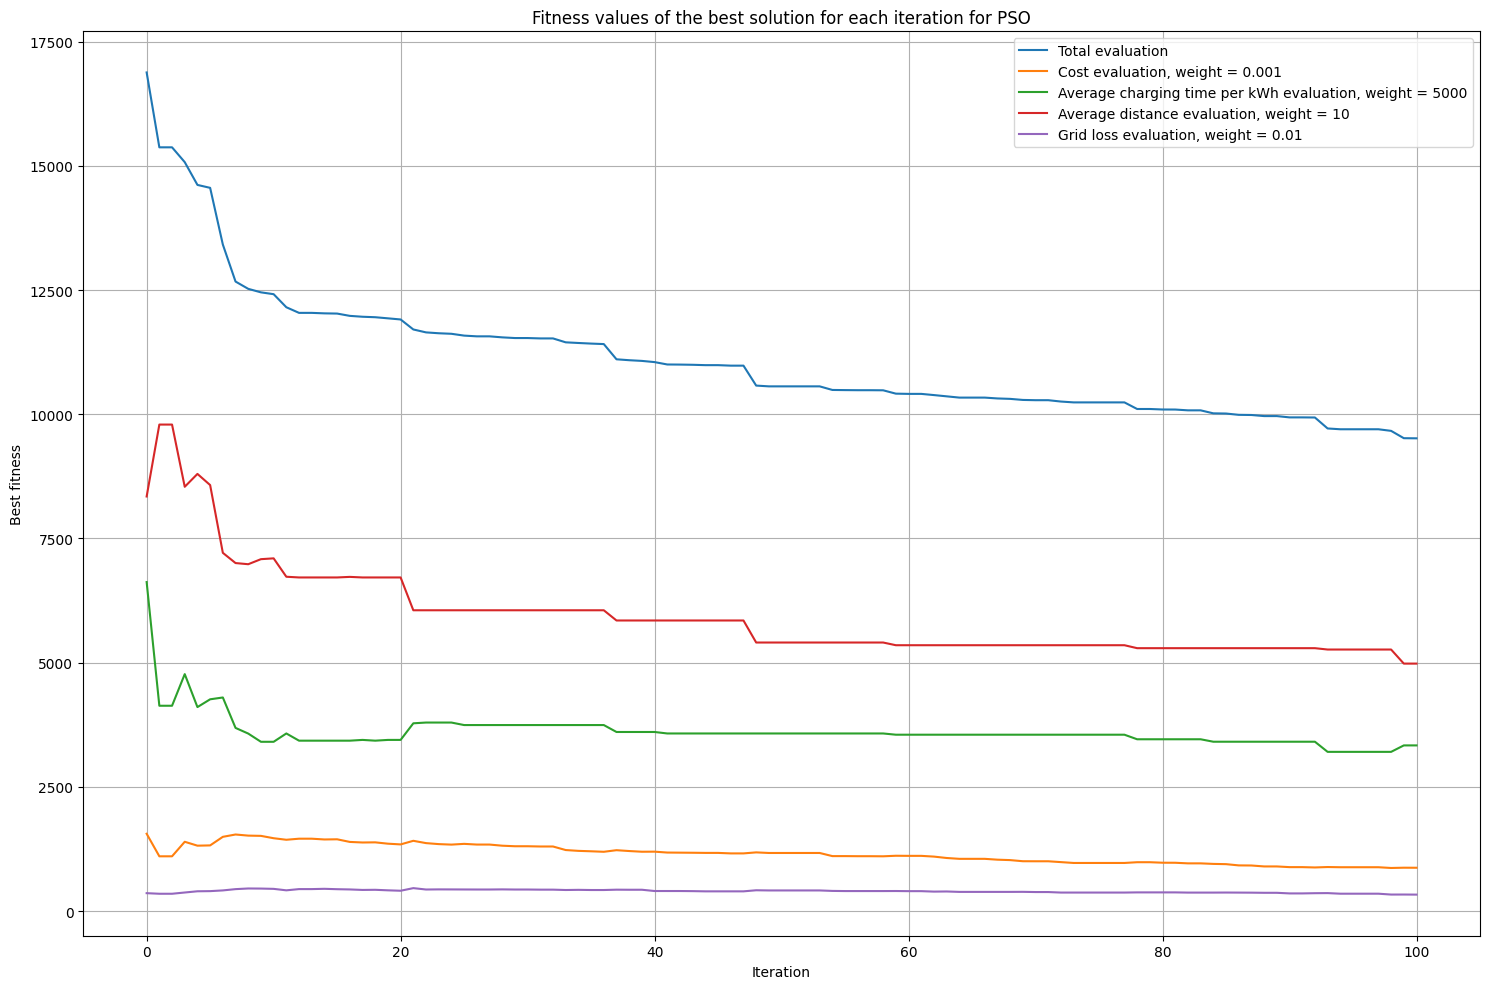

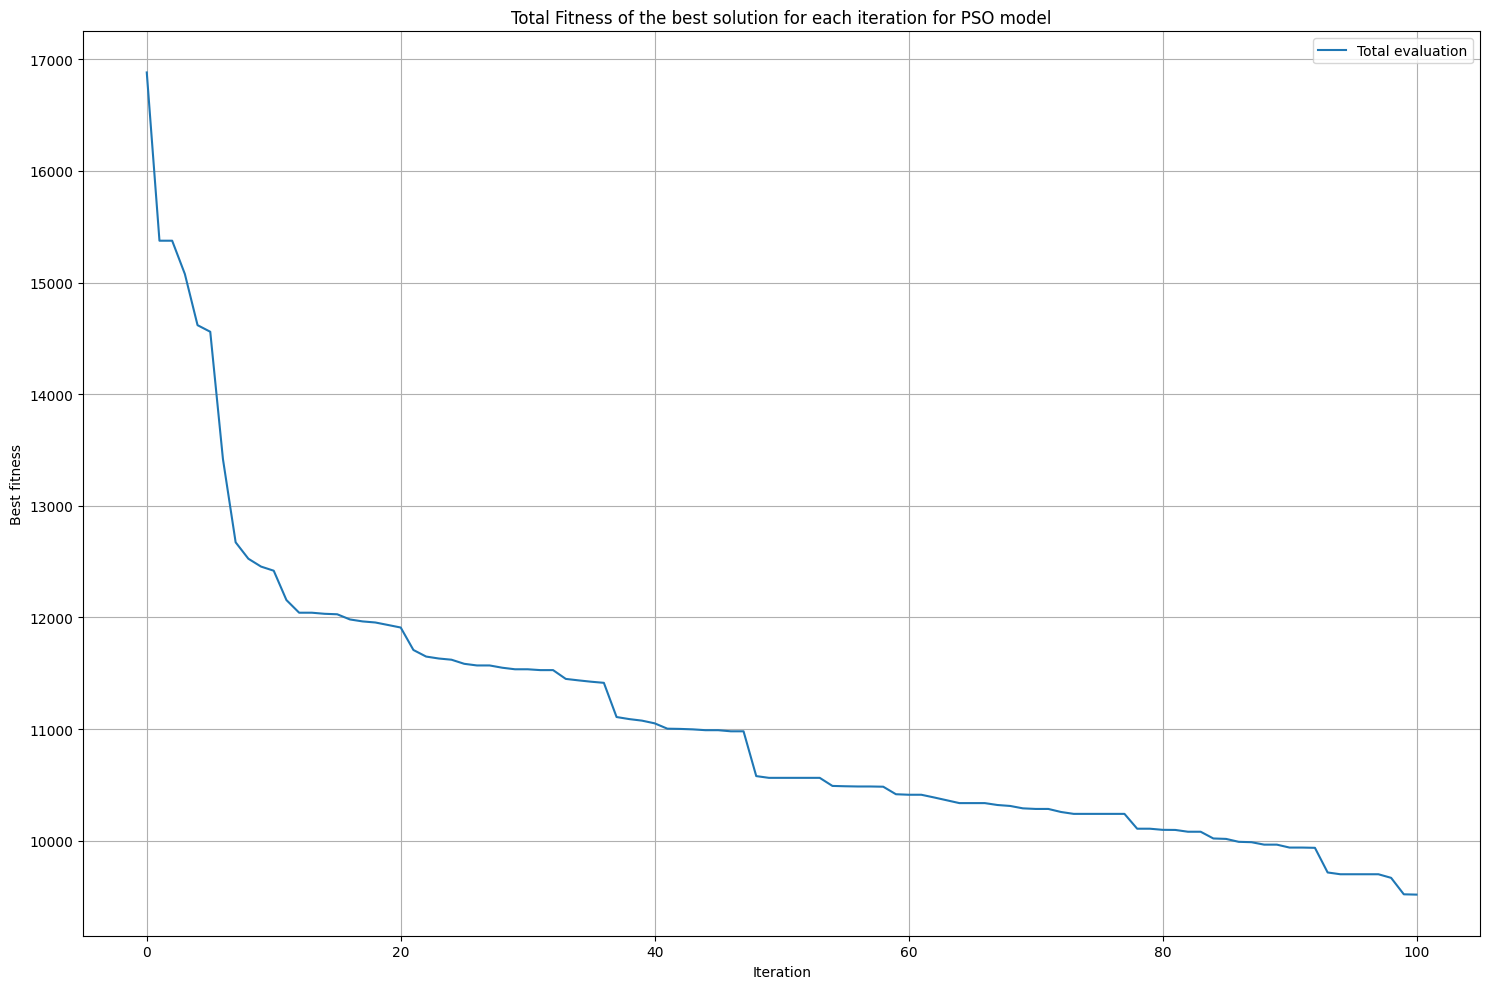

C:\Users\tetia\AppData\Local\Temp\ipykernel_39452\2865980958.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


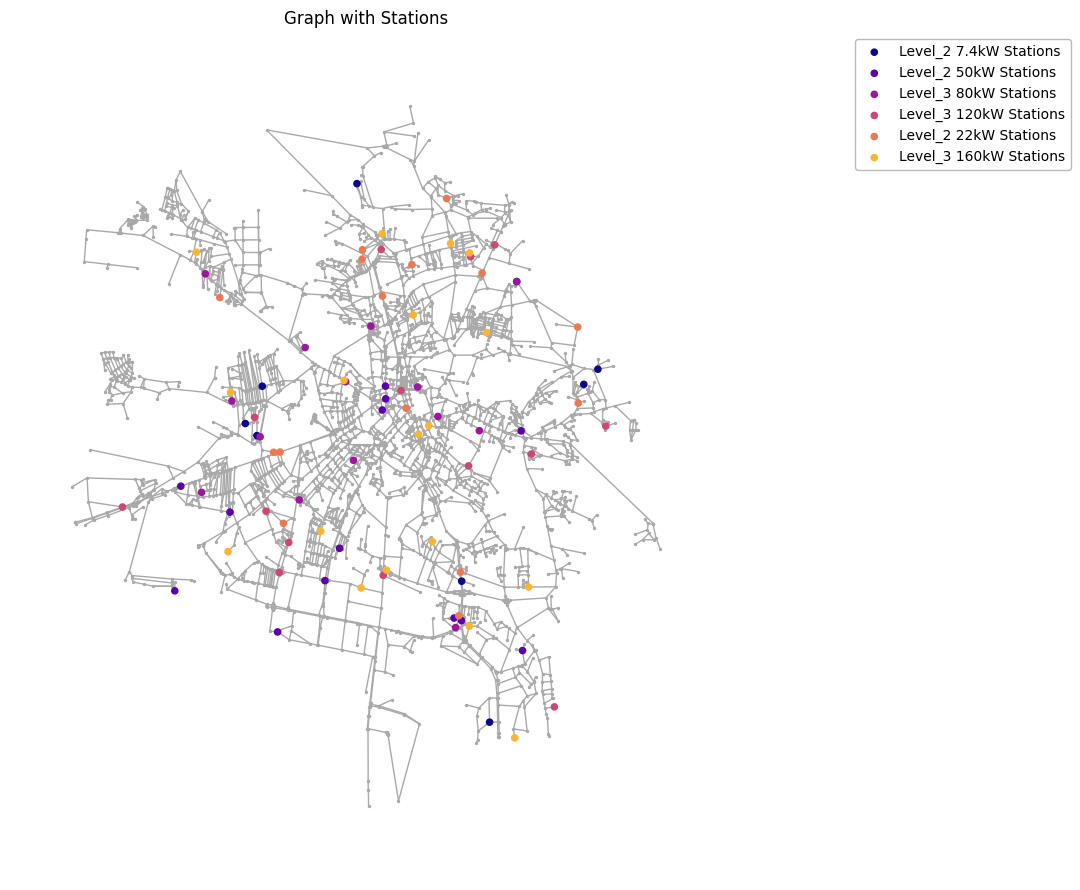

In [108]:
plot_models_fitness(exp_result6["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result6["fitness_history"])
visualize_solution(exp_result6["solution"], G)

## Experiment 7

- base parameters
- generations = 150
- parents = 80

In [ ]:
run_pso("configs/params.yaml", "exp_pso_7.pkl", exp_config_file = "configs/experiments/exp_pso_7.yaml")

In [109]:
with open("exp_pso_7.pkl", "rb") as f:
    exp_result7 = pickle.load(f)
exp_result7["runtime"]

6737.422424554825

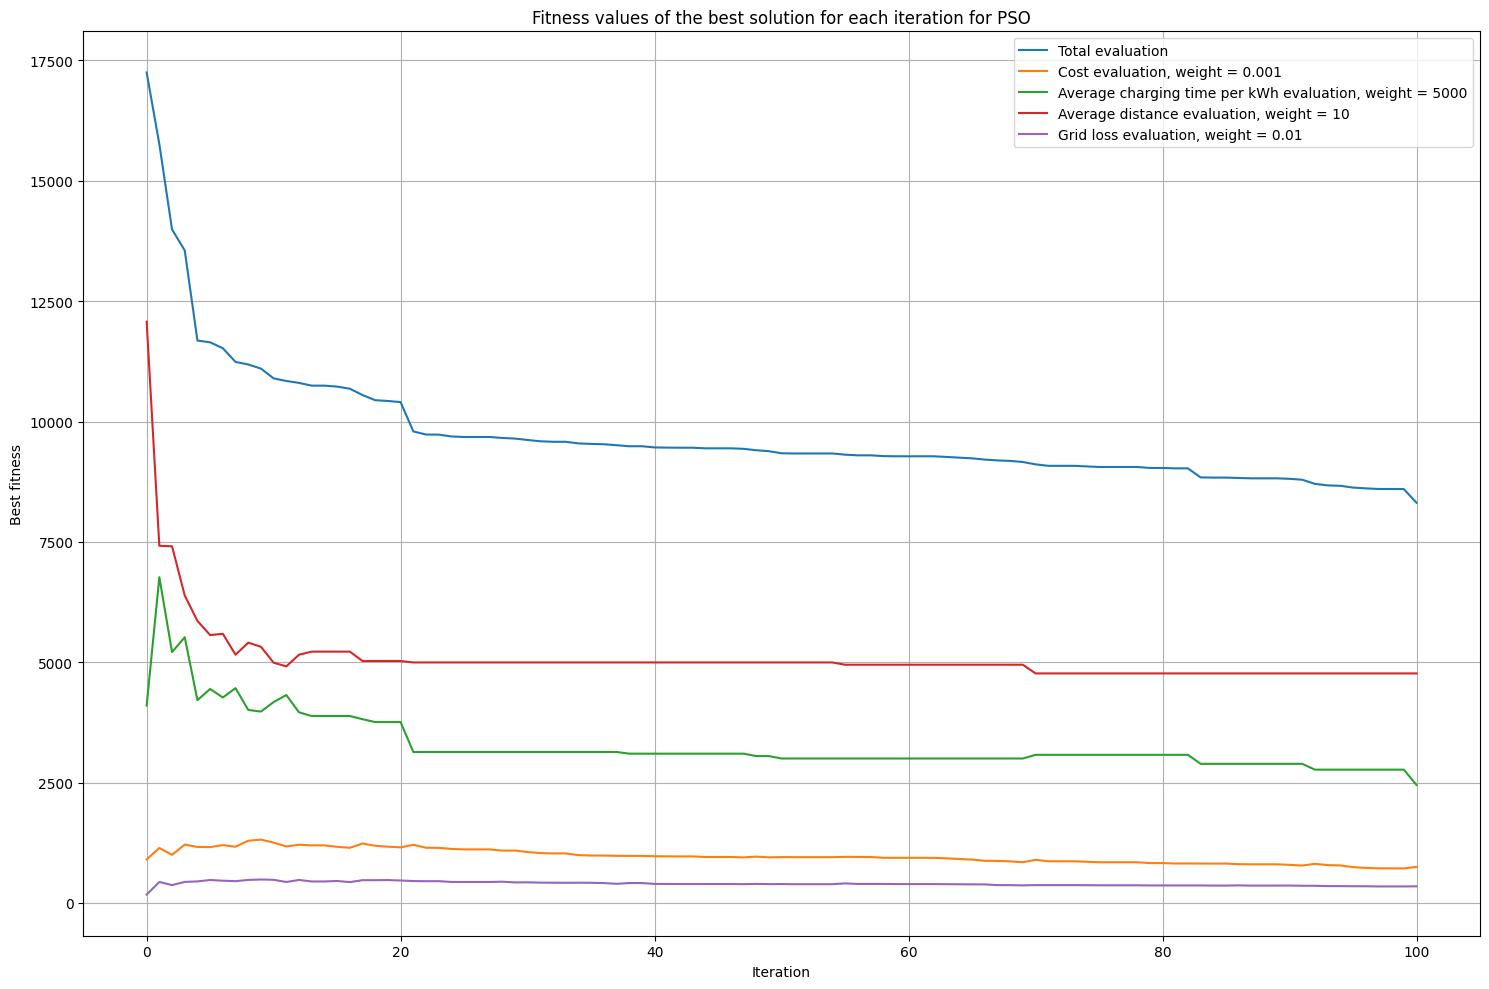

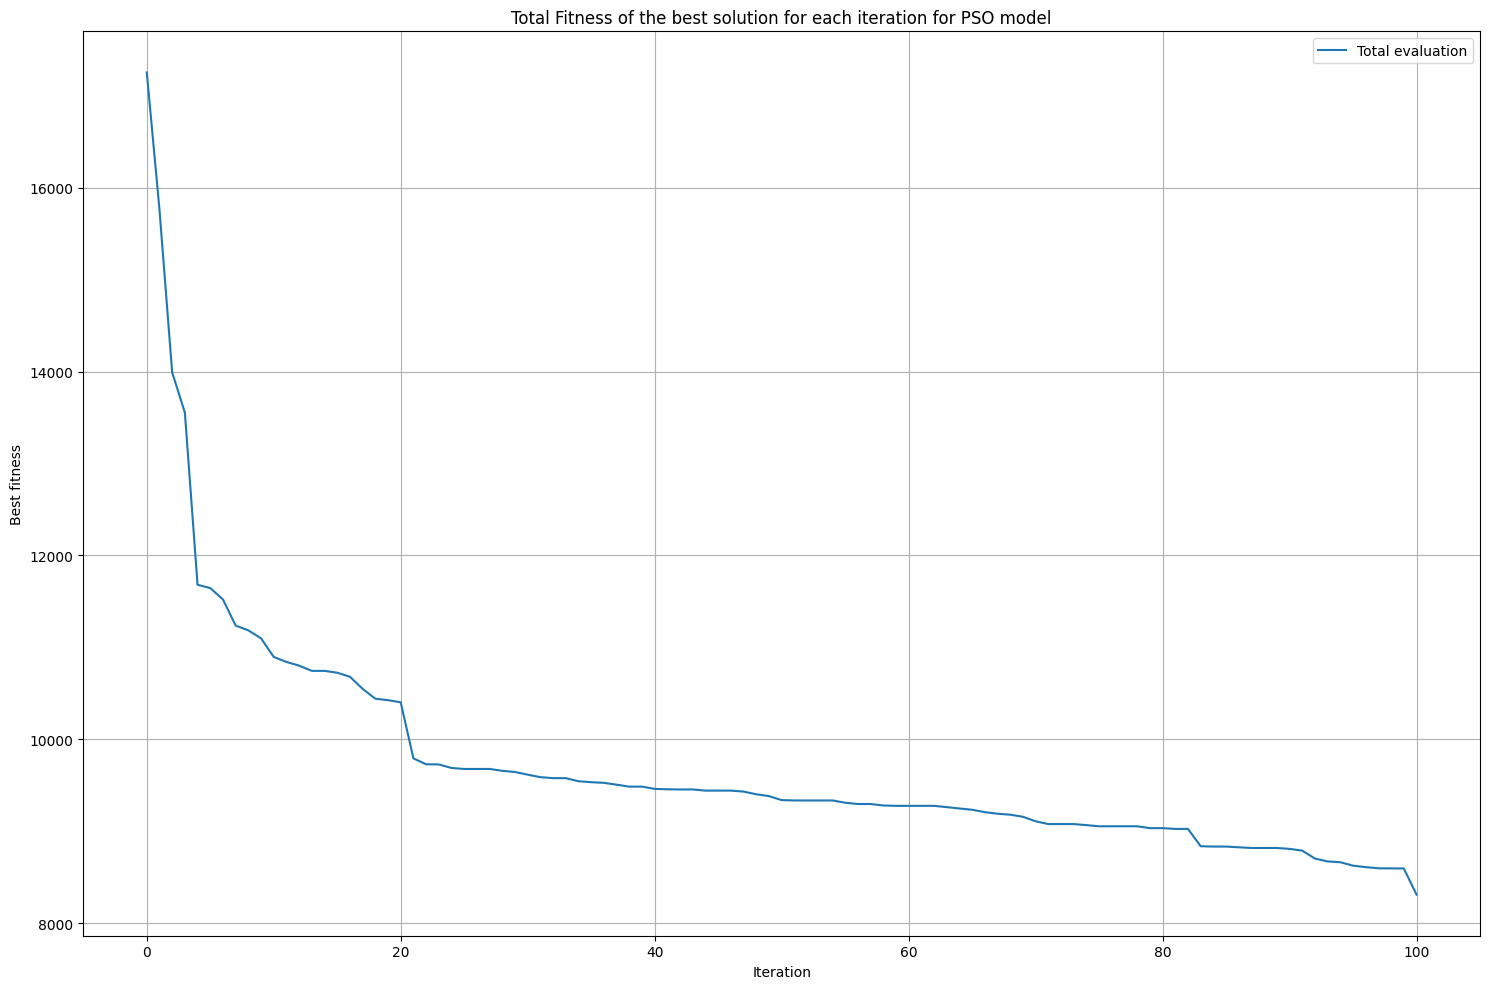

C:\Users\tetia\AppData\Local\Temp\ipykernel_39452\2865980958.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


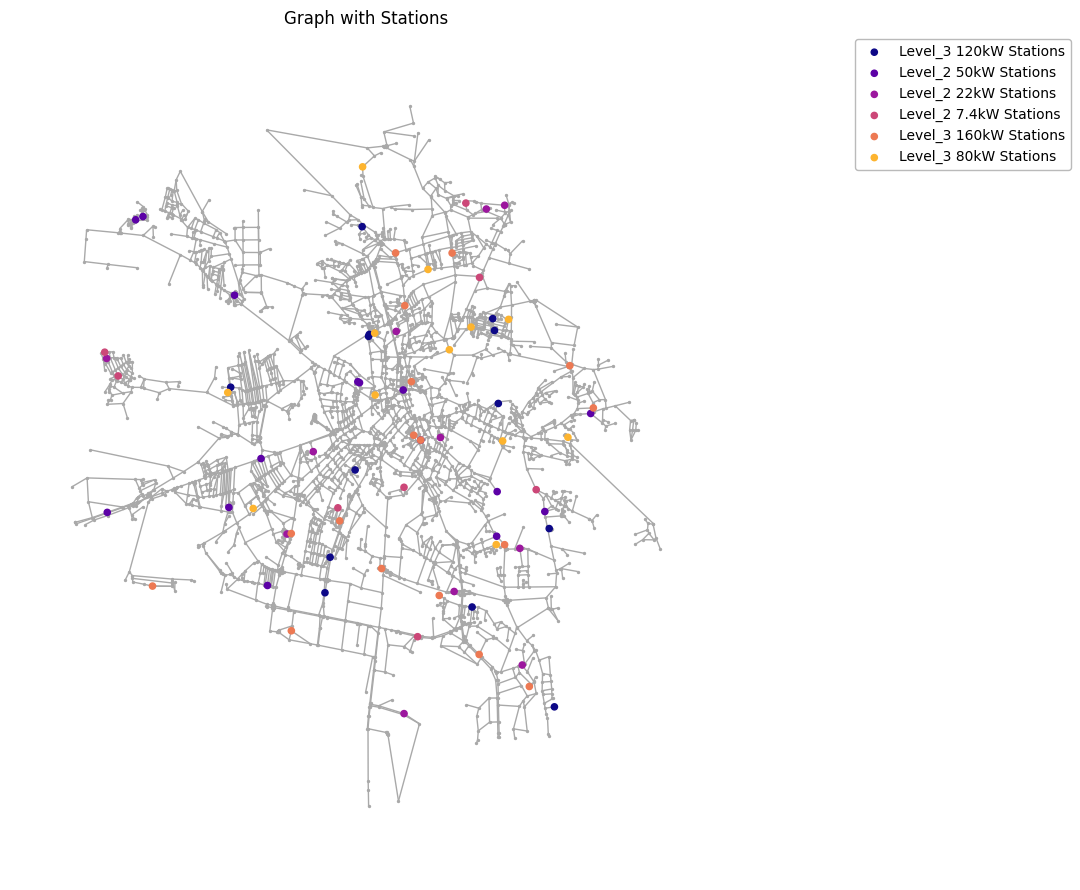

In [110]:
plot_models_fitness(exp_result7["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result7["fitness_history"])
visualize_solution(exp_result7["solution"], G)

## Experiment 8

- base parameters
- city = Kyiv

In [ ]:
run_pso("configs/params.yaml", "exp_pso_8.pkl", exp_config_file = "configs/experiments/exp_pso_8.yaml")

In [111]:
with open("exp_pso_8.pkl", "rb") as f:
    exp_result8 = pickle.load(f)
exp_result8["runtime"]

7742.988232851028

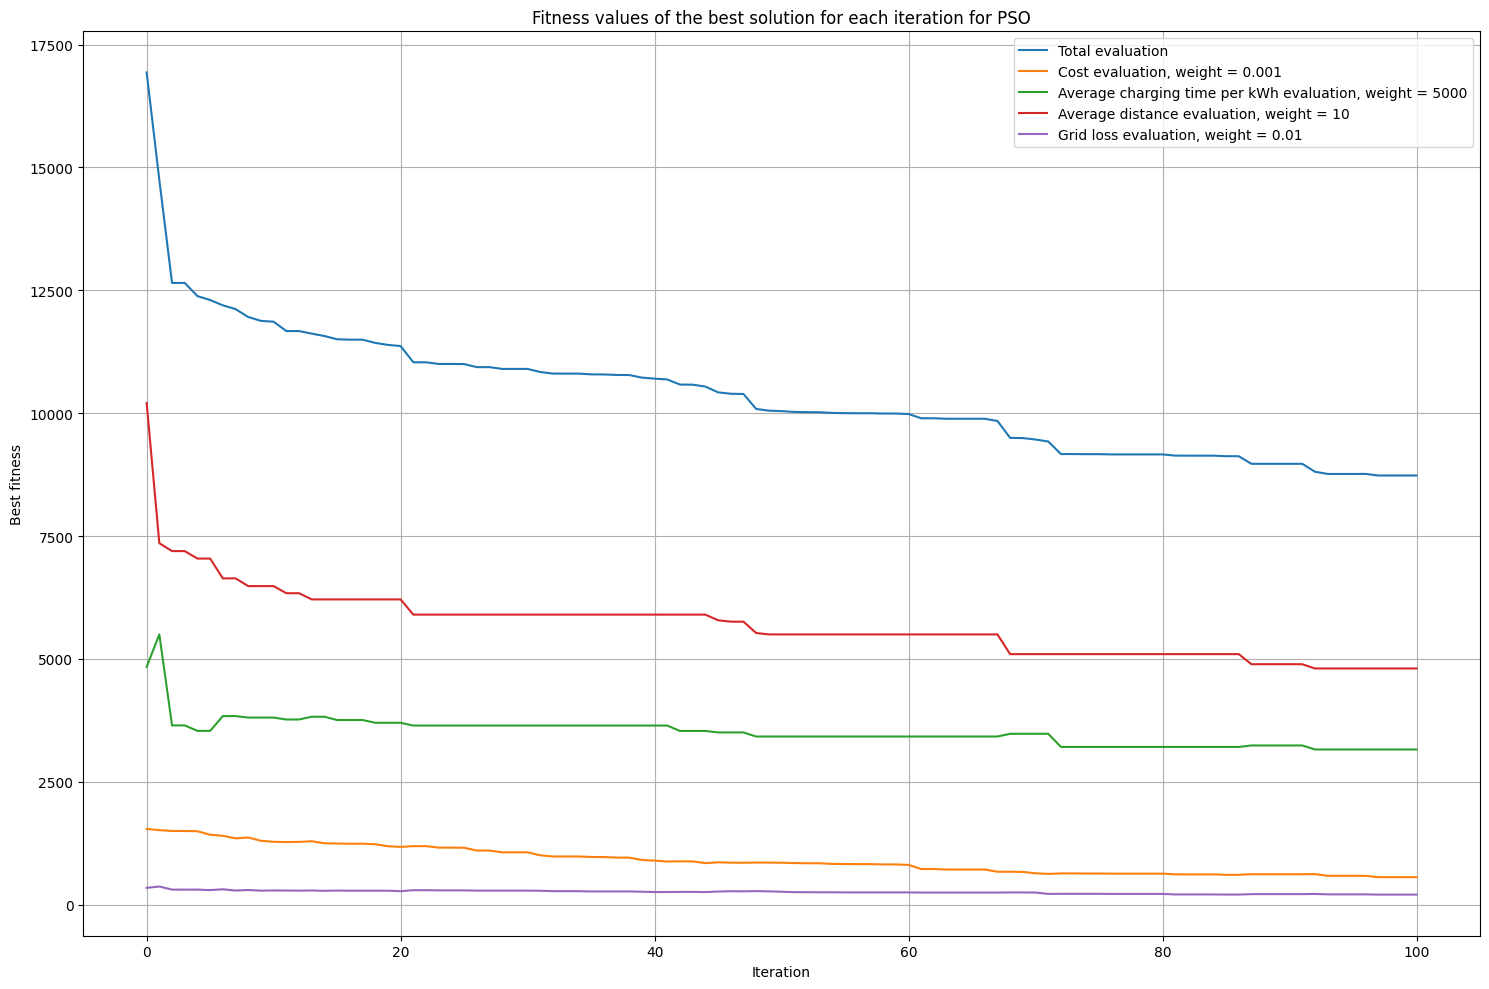

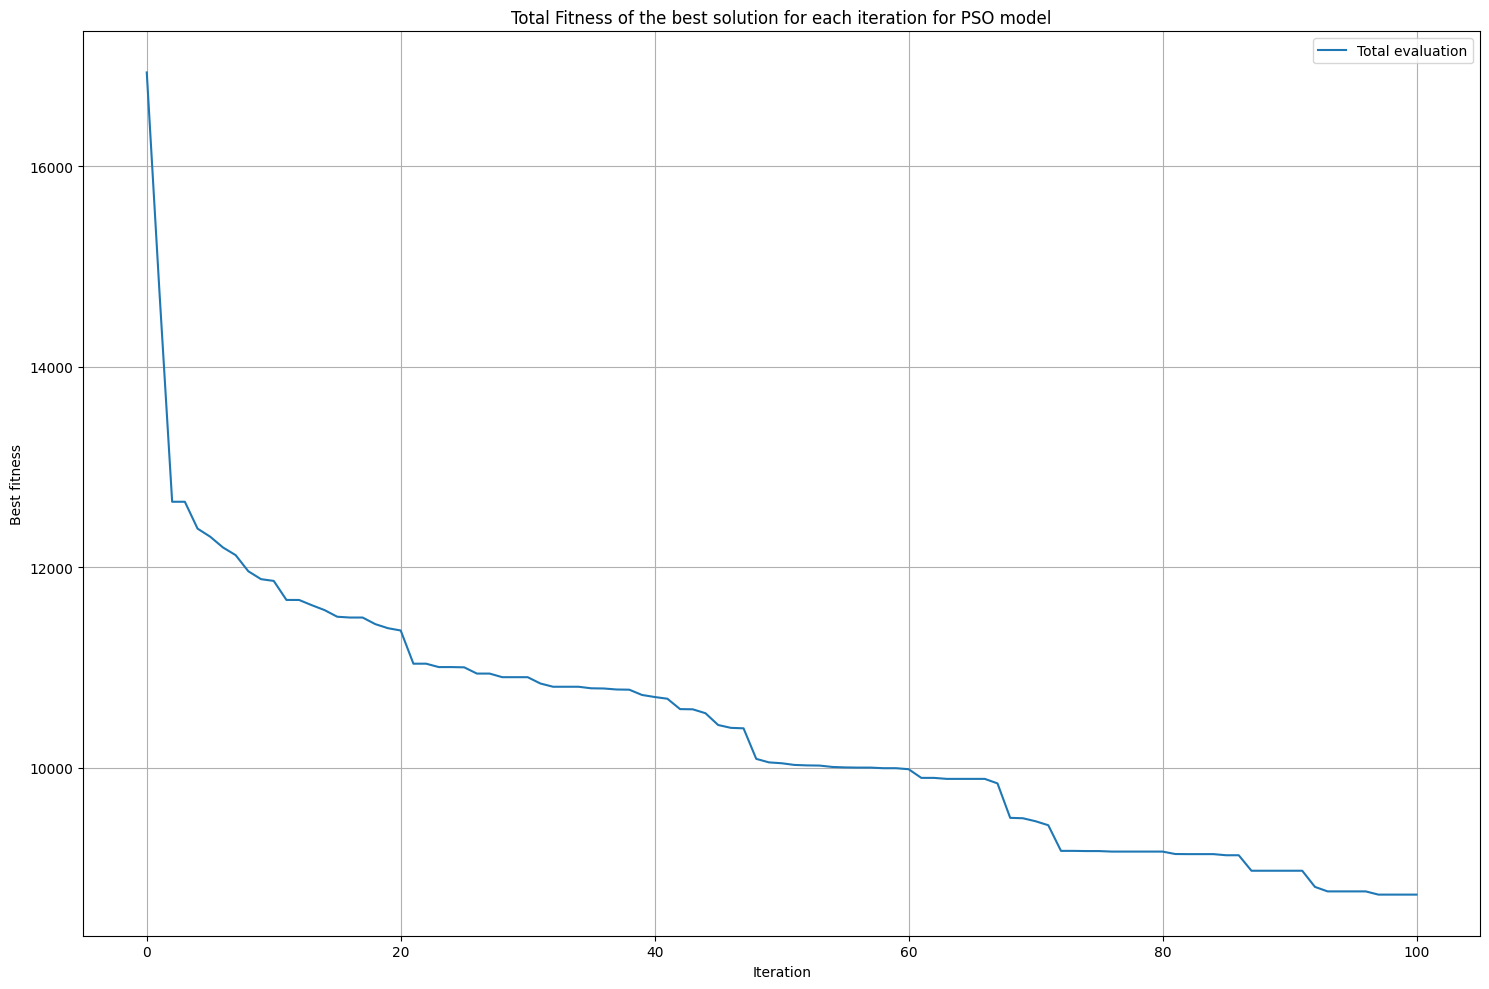

C:\Users\tetia\AppData\Local\Temp\ipykernel_39452\2865980958.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


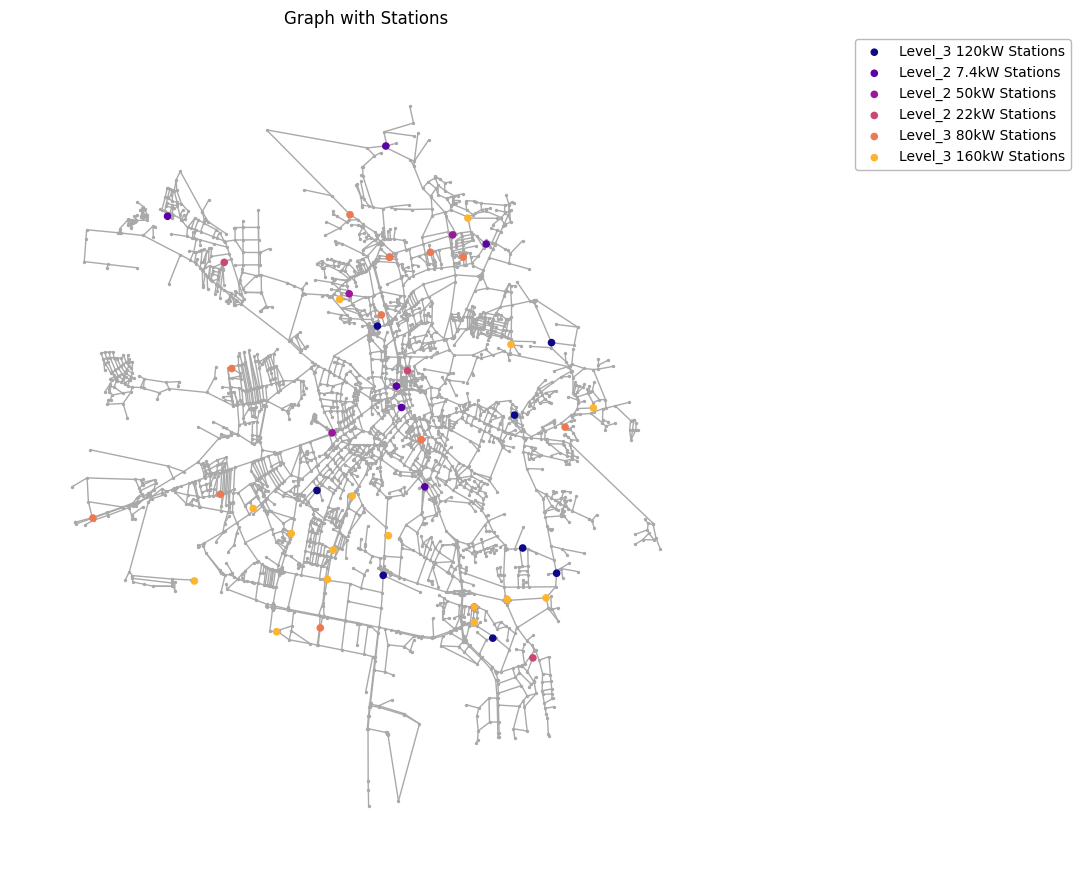

In [112]:
plot_models_fitness(exp_result8["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result8["fitness_history"])
visualize_solution(exp_result8["solution"], G)

## Experiment 9

- base parameters
- EV per capita

In [ ]:
run_pso("configs/params.yaml", "exp_pso_9.pkl", exp_config_file = "configs/experiments/exp_pso_9.yaml")

In [ ]:
with open("exp_pso_9.pkl", "rb") as f:
    exp_result9 = pickle.load(f)
exp_result9["runtime"]

In [ ]:
plot_models_fitness(exp_result9["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result9["fitness_history"])
visualize_solution(exp_result9["solution"], G)